In [5]:
import sys
# sys.path.append("/root/project/SeqFMER/src")

import pandas as pd
import numpy as np

import time
import random
import models
import pysam
import utils
import captum
# from tqdm import tqdm
from captum import *
import torch
from torch.utils.data import Dataset,DataLoader


# import seaborn as sns
import matplotlib.pyplot as plt
#高清显示
%config InlineBackend.figure_format = 'retina'
#设置风格为matplotlib默认风格
# sns.set_style("white")
#设置字体为times new roman
# plt.rcParams['font.family'] = 'Arial'
#设置字体大小为12
# plt.rcParams['font.size'] = 12

In [6]:
linear_units_dict = {
    "DeepSEA": {
        "200bp": 35520,
        "400bp": 83520,
        "600bp": 131520,
        "800bp": 179520,
        "1000bp": 227520
    },
    "Basset": {
        "200bp": 4600,
        "400bp": 9600,
        "600bp": 14600,
        "800bp": 19600,
        "1000bp": 24600
    },
    "DanQ": {
        "200bp": 9600,
        "400bp": 19200,
        "600bp": 29440,
        "800bp": 39040,
        "1000bp": 48640
    },
    "ExplaiNN": {
        "200bp": 200,
        "400bp": 400,
        "600bp": 600,
        "800bp": 800,
        "1000bp": 1000
    },
    "SATORI": {
        "200bp": 10240,
        "400bp": 20480,
        "600bp": 30720,
        "800bp": 40960,
        "1000bp": 51200
    },
    "CNN_Transformer": {
        "200bp": 6000,
        "400bp": 12000,
        "600bp": 18000,
        "800bp": 24000,
        "1000bp": 30000
    },
    "CNN_Attention": {
        "200bp": 6000,
        "400bp": 12000,
        "600bp": 18000,
        "800bp": 24000,
        "1000bp": 30000
    },
    "CNN": {
        "200bp": 9900,
        "400bp": 19800,
        "600bp": 30000,
        "800bp": 39900,
        "1000bp": 49800
    }
}

In [7]:
class BinaryDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
    
# Create a custom collate function
def get_custom_collate_fn(fasta):
    def custom_collate_fn(batch):
        # 初始化序列和标签的列表
        sequences = []
        
        # 遍历batch中的每个(data, label)对
        for item in batch:
            sequence = utils.onehot_seq(fasta.fetch(item[0], int(item[1]), int(item[2])))
            sequences.append(sequence)
        
        # 将序列和标签列表转换为张量
        sequences_tensor = torch.FloatTensor(np.array(sequences))
        
        return sequences_tensor
    return custom_collate_fn



def calc_motif_IC(motif, background=0.25):
    """IC Bernouli"""
    H = (motif * np.log2(motif / background + 1e-6)).sum()
    return H
class ActivateFeaturesHook():
    def __init__(self,module) -> None:
        self.hook = module.register_forward_hook(self.hook_fn)
    def hook_fn(self,module,input,output):
        self.features = output.cpu().data.numpy()
    def get_features(self):
        return self.features
    def close(self):
        self.hook.remove()

def get_fmap(model,hook_module,data_loader,device):
    fmap,X = [],[]
    model.eval()
    with torch.no_grad():
        activations = ActivateFeaturesHook(hook_module)
        for x_tensor in data_loader:
            x_tensor = x_tensor.float().to(device).transpose(2,1)
            _ = model(x_tensor)
            X.append(x_tensor.cpu().numpy())
            fmap.append(activations.get_features())
            # atten_matrix.append(atten.cpu().detach().numpy())
        fmap = np.vstack(fmap)
        X = np.vstack(X)
        # atten_matrix = np.vstack(atten_matrix)
        activations.close()
    
    return fmap,X

def get_activate_W_from_fmap(fmap, X,padding,pool=1, threshold=0.99, motif_width=10):
    """
    get learned motif pwm based on motif_width
    """
    motif_nb = fmap.shape[1]
    X_dim, seq_len = X.shape[1], X.shape[-1]

    W=[]
    seq_ls = []
    for filter_index in range(motif_nb):
        # find regions above threshold
        data_index, pos_index = np.where(fmap[:,filter_index,:] > np.max(fmap[:,filter_index,:])*threshold)#np.where(fmap[:,filter_index,:] > np.max(fmap[:,filter_index,:], axis=1, keepdims=True)*threshold)

        seq_align = []; count_matrix = []
        for i in range(len(pos_index)):
            # pad 1-nt
            start = pos_index[i] - padding
            end = start + motif_width + 2
            # handle boundary conditions
            if end > seq_len:
                end = seq_len
                start = end - motif_width - 2 
            if start < 0:
                start = 0 
                end = start + motif_width + 2 

            seq = X[data_index[i], :, start*pool:end*pool]
            seq_align.append(seq)
            count_matrix.append(np.sum(seq, axis=0, keepdims=True))

        seq_align = np.array(seq_align)
        seq_ls.append(seq_align)
        count_matrix = np.array(count_matrix)

        # normalize counts
        seq_align = (np.sum(seq_align, axis=0)/np.sum(count_matrix, axis=0))*np.ones((X_dim, (motif_width+2)*pool))
        seq_align[np.isnan(seq_align)] = 0
        W.append(seq_align)

    W = np.array(W)
    return W,seq_ls


def meme_generate_top(W,tf_list, output_file='meme.txt', prefix='Motif_'):
    # background frequency
    nt_freqs = [1./4 for i in range(4)]

    # open file for writing
    f = open(output_file, 'w')

    # print intro material
    f.write('MEME version 4\n')
    f.write('\n')
    f.write('ALPHABET= ACGT\n')
    f.write('\n')
    f.write('strands: + -\n')
    f.write('\n')
    f.write('Background letter frequencies:\n')
    f.write('A %.4f C %.4f G %.4f T %.4f \n' % tuple(nt_freqs))
    f.write('\n')

    for j in range(len(W)):
        if j in tf_list:
            pwm = W[j]
            if np.sum(pwm)>0:
                f.write('MOTIF %s%d %d\n' % (prefix, j, j))
                f.write('\n')
                f.write('letter-probability matrix: alength= 4 w= %d nsites= %d E= 0\n' % (pwm.shape[1], pwm.shape[1]))
                for i in range(pwm.shape[1]):
                    f.write('  %.4f\t  %.4f\t  %.4f\t  %.4f\t\n' % tuple(pwm[:,i]))
                f.write('\n')

    f.close()


def meme_generate(W, output_file='meme.txt', prefix='Motif_'):
    # background frequency
    nt_freqs = [1./4 for i in range(4)]

    # open file for writing
    f = open(output_file, 'w')

    # print intro material
    f.write('MEME version 4\n')
    f.write('\n')
    f.write('ALPHABET= ACGT\n')
    f.write('\n')
    f.write('strands: + -\n')
    f.write('\n')
    f.write('Background letter frequencies:\n')
    f.write('A %.4f C %.4f G %.4f T %.4f \n' % tuple(nt_freqs))
    f.write('\n')

    for j in range(len(W)):
        pwm = W[j]
        if np.sum(pwm)>0:
            f.write('MOTIF %s%d %d\n' % (prefix, j, j))
            f.write('\n')
            f.write('letter-probability matrix: alength= 4 w= %d nsites= %d E= 0\n' % (pwm.shape[1], pwm.shape[1]))
            for i in range(pwm.shape[1]):
                f.write('  %.4f\t  %.4f\t  %.4f\t  %.4f\t\n' % tuple(pwm[:,i]))
            f.write('\n')

    f.close()

In [8]:
fasta_paths = {
    "human":"/root/project/SeqFMER/data/ref/hg38.fa"
}

In [136]:
for length in [200,400,600,800,1000]:
    for phase in ["GM12878","T-cell"]:
        for activate in ["relu","exp"]:
            for method in ["Basset","DanQ","ExplaiNN","CNN_Transformer","CNN"]:
                device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
                model = eval(f'models.{method}(1, linear_units_dict["{method}"]["{length}bp"], activate="{activate}")')
                model.load_state_dict(torch.load(f"/mnt/d/work/2023/1/NCBenchmark/train_results/{phase}/{method}_40_{length}_{activate}_best_network.pth",map_location=device))
                model.to(device)
                model.eval()

                data_path = f"/mnt/d/work/2023/1/NCBenchmark/data/{phase}/train_test_{length}.npz"
                data_ = np.load(data_path)
                val_dataset = BinaryDataset(data_["test_data"][0:2000])
                fasta = pysam.FastaFile(fasta_paths["human"])
                val_loader = DataLoader(val_dataset, batch_size=int(128), shuffle=False, collate_fn=get_custom_collate_fn(fasta),num_workers=10)
                fmap,X = get_fmap(model,next(model.children())[0],val_loader,device=device)
                W,seq_ls = get_activate_W_from_fmap(fmap,X,threshold=0.85,motif_width=17,padding=9)
                motif_ic = []
                for i in range(len(W)):
                    ic = calc_motif_IC(W[i])
                    motif_ic.append(ic)
                motif_ic_df = pd.DataFrame(motif_ic)
                motif_ic_df.to_csv(f"/mnt/d/work/2023/1/NCBenchmark/meme/{length}/motif_ic_{phase}_{method}_{activate}.csv",index=False,header=False)
                meme_generate(W,output_file=f"/mnt/d/work/2023/1/NCBenchmark/meme/{length}/motif_{phase}_{method}_{activate}.meme")
# data_path = f"/mnt/d/work/2023/1/NCBenchmark/NCBenchmark/data/embryo/{specie}/{phase}/{phase}_peaks.narrowPeak_train_test_600.npz"
# data_ = np.load(data_path)
# val_dataset = BinaryDataset(data_["test_data"][0:2000])
# fasta = pysam.FastaFile(fasta_paths[specie])
# val_loader = DataLoader(val_dataset, batch_size=int(128), shuffle=False, collate_fn=get_custom_collate_fn(fasta),num_workers=10)
# fmap,X = get_fmap(model,next(model.children())[0],val_loader,device=device)
# W,seq_ls = get_activate_W_from_fmap(fmap,X,threshold=0.85,motif_width=17,padding=9)

# df_explainn = pd.DataFrame(model.explainn[11].weight.data.detach().cpu().numpy().reshape(-1))
# tf_list = df_explainn.sort_values(0,ascending=False).head(20).index
# meme_generate(W,tf_list,output_file=f"/mnt/d/work/2023/1/NCBenchmark/NCBenchmark/train_results/Embryo/{specie}/{phase}/motif.meme")

/tmp/ipykernel_3376948/1814476671.py:97: RuntimeWarning: invalid value encountered in scalar divide
  seq_align = (np.sum(seq_align, axis=0)/np.sum(count_matrix, axis=0))*np.ones((X_dim, (motif_width+2)*pool))


In [18]:
#评估不同方法发现motif的能力
df_basset = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/meme/600/GM12878/relu/Basset/tomtom.tsv",sep="\t").iloc[0:-3,:]
df_danq = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/meme/600/GM12878/relu/DanQ/tomtom.tsv",sep="\t").iloc[0:-3,:]
df_explainn = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/meme/600/GM12878/relu/ExplaiNN/tomtom.tsv",sep="\t").iloc[0:-3,:]
df_cnn = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/meme/600/GM12878/relu/CNN/tomtom.tsv",sep="\t").iloc[0:-3,:]
df_cnn_transformer = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/meme/600/GM12878/relu/CNN_Transformer/tomtom.tsv",sep="\t").iloc[0:-3,:]

df_basset_exp = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/meme/600/GM12878/exp/Basset/tomtom.tsv",sep="\t").iloc[0:-3,:]
df_danq_exp = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/meme/600/GM12878/exp/DanQ/tomtom.tsv",sep="\t").iloc[0:-3,:]
df_explainn_exp = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/meme/600/GM12878/exp/ExplaiNN/tomtom.tsv",sep="\t").iloc[0:-3,:]
df_cnn_exp = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/meme/600/GM12878/exp/CNN/tomtom.tsv",sep="\t").iloc[0:-3,:]
df_cnn_transformer_exp = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/meme/600/GM12878/exp/CNN_Transformer/tomtom.tsv",sep="\t").iloc[0:-3,:]

In [120]:
df_cnn_transformer

,Query_ID,Target_ID,Optimal_offset,p-value,E-value,q-value,Overlap,Query_consensus,Target_consensus,Orientation,method
0,Motif_0,MA1125.1,-7.0,0.000015,0.012407,0.024701,12.0,TAATTTTTTTTTTTTTTTT,TTTTTTTTTAAA,-,Transformer
1,Motif_0,MA0679.2,-1.0,0.000062,0.052098,0.051862,16.0,TAATTTTTTTTTTTTTTTT,TATTTATTGATTTTTT,-,Transformer
2,Motif_0,MA1978.1,3.0,0.000226,0.190202,0.126227,18.0,TAATTTTTTTTTTTTTTTT,AATTAGTCCATTTATATTTAT,-,Transformer
3,Motif_0,MA1989.1,-3.0,0.000424,0.356256,0.154431,14.0,TAATTTTTTTTTTTTTTTT,TTCTTGTGGTTTTT,-,Transformer
4,Motif_0,MA0898.1,-2.0,0.000521,0.438273,0.154431,17.0,TAATTTTTTTTTTTTTTTT,ATTCTTTAATTGCTTGT,-,Transformer
...,...,...,...,...,...,...,...,...,...,...,...
4022,Motif_299,MA1985.1,-4.0,0.008561,7.199650,0.999990,15.0,TTGAAAATGTCGGCTCCCC,AGTGGTCATCGCCCC,-,Transformer
4023,Motif_299,MA1651.1,2.0,0.008747,7.356580,0.999990,19.0,TTGAAAATGTCGGCTCCCC,GTTCCAAAATGGCTGCCTCCG,+,Transformer
4024,Motif_299,MA0495.3,0.0,0.010598,8.912930,0.999990,16.0,TTGAAAATGTCGGCTCCCC,AAAAAAATGCTGACTT,-,Transformer
4025,Motif_299,MA0095.3,0.0,0.011121,9.352800,0.999990,12.0,TTGAAAATGTCGGCTCCCC,AACAAAATGGCG,+,Transformer


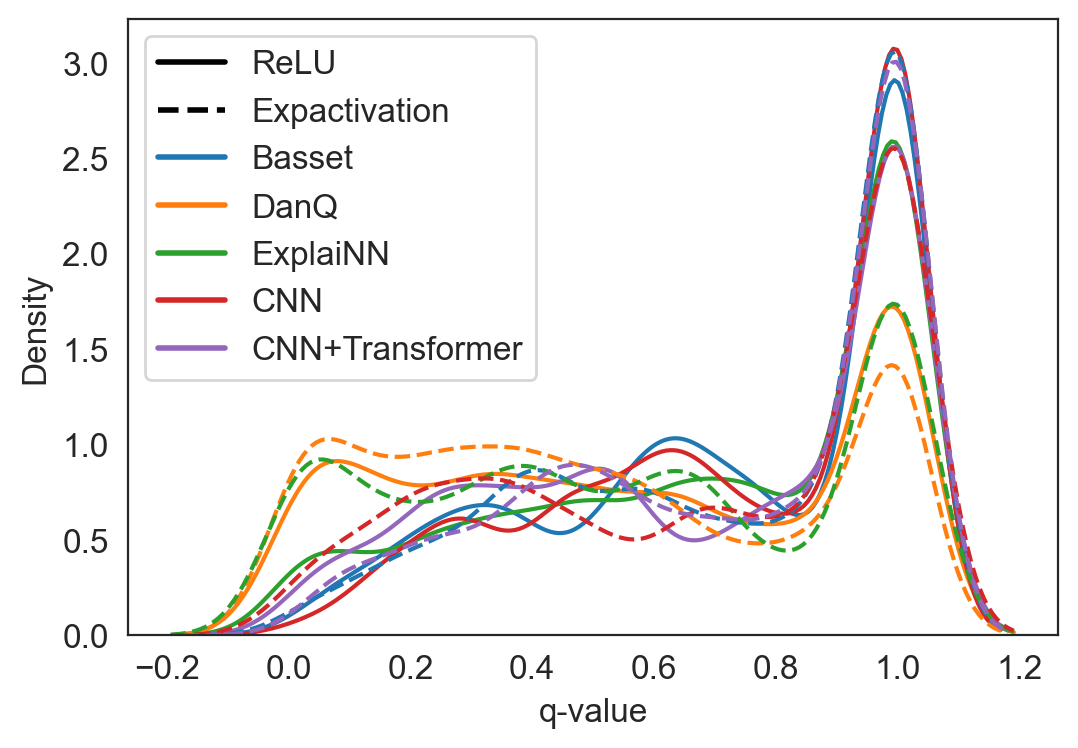

In [38]:
#绘制q-value核密度估计图
# plt.figure(figsize=(6,4))
# sns.kdeplot(df_basset["q-value"],fill=False,label="Basset")
# sns.kdeplot(df_danq["q-value"],fill=False,label="DanQ")
# sns.kdeplot(df_explainn["q-value"],fill=False,label="ExplaiNN")
# sns.kdeplot(df_cnn["q-value"],fill=False,label="CNN")
# sns.kdeplot(df_cnn_transformer["q-value"],fill=False,label="CNN+Transformer")

# sns.kdeplot(df_basset_exp["q-value"],fill=False,label="Basset",linestyle='--')
# sns.kdeplot(df_danq_exp["q-value"],fill=False,label="DanQ",linestyle='--')
# sns.kdeplot(df_explainn_exp["q-value"],fill=False,label="ExplaiNN",linestyle='--')
# sns.kdeplot(df_cnn_exp["q-value"],fill=False,label="CNN",linestyle='--')
# sns.kdeplot(df_cnn_transformer_exp["q-value"],fill=False,label="CNN+Transformer",linestyle='--')

# 设置颜色
palette = sns.color_palette("tab10")

# 绘制KDE图
plt.figure(figsize=(6, 4))

sns.kdeplot(df_basset["q-value"], fill=False, label="Basset (ReLU)", color=palette[0])
sns.kdeplot(df_danq["q-value"], fill=False, label="DanQ (ReLU)", color=palette[1])
sns.kdeplot(df_explainn["q-value"], fill=False, label="ExplaiNN (ReLU)", color=palette[2])
sns.kdeplot(df_cnn["q-value"], fill=False, label="CNN (ReLU)", color=palette[3])
sns.kdeplot(df_cnn_transformer["q-value"], fill=False, label="CNN+Transformer (ReLU)", color=palette[4])

sns.kdeplot(df_basset_exp["q-value"], fill=False, label="Basset (Exp)", color=palette[0], linestyle='--')
sns.kdeplot(df_danq_exp["q-value"], fill=False, label="DanQ (Exp)", color=palette[1], linestyle='--')
sns.kdeplot(df_explainn_exp["q-value"], fill=False, label="ExplaiNN (Exp)", color=palette[2], linestyle='--')
sns.kdeplot(df_cnn_exp["q-value"], fill=False, label="CNN (Exp)", color=palette[3], linestyle='--')
sns.kdeplot(df_cnn_transformer_exp["q-value"], fill=False, label="CNN+Transformer (Exp)", color=palette[4], linestyle='--')

# 自定义图例
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color="black", lw=2, label='ReLU'),
    Line2D([0], [0], color="black", lw=2, linestyle='--', label='Expactivation'),
    Line2D([0], [0], color=palette[0], lw=2, label='Basset'),
    Line2D([0], [0], color=palette[1], lw=2, label='DanQ'),
    Line2D([0], [0], color=palette[2], lw=2, label='ExplaiNN'),
    Line2D([0], [0], color=palette[3], lw=2, label='CNN'),
    Line2D([0], [0], color=palette[4], lw=2, label='CNN+Transformer'),
]

plt.legend(handles=legend_elements)
plt.savefig("/mnt/d/work/2023/1/NCBenchmark/Figure/Figure_fig/explainn/q_value_density.pdf",bbox_inches='tight')

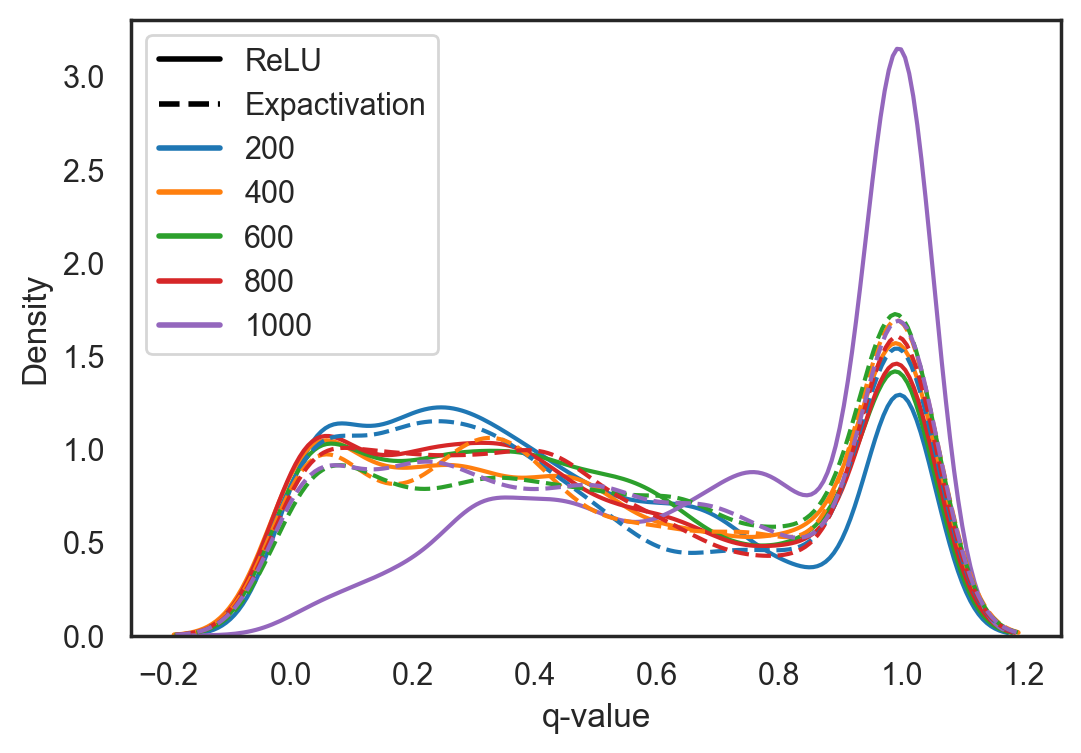

In [73]:
#绘制q-value核密度估计图
#评估不同方法发现motif的能力
# df_danq_200 = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/meme/200/GM12878/exp/DanQ/tomtom.tsv",sep="\t").iloc[0:-3,:]
# df_danq_400 = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/meme/400/GM12878/exp/DanQ/tomtom.tsv",sep="\t").iloc[0:-3,:]
# df_danq_600 = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/meme/600/GM12878/exp/DanQ/tomtom.tsv",sep="\t").iloc[0:-3,:]
# df_danq_800 = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/meme/800/GM12878/exp/DanQ/tomtom.tsv",sep="\t").iloc[0:-3,:]
# df_danq_1000 = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/meme/1000/GM12878/exp/DanQ/tomtom.tsv",sep="\t").iloc[0:-3,:]

# plt.figure(figsize=(6,4))
# sns.kdeplot(df_danq_200["q-value"],label="200")
# sns.kdeplot(df_danq_400["q-value"],label="400")
# sns.kdeplot(df_danq_600["q-value"],label="600")
# sns.kdeplot(df_danq_800["q-value"],label="800")
# sns.kdeplot(df_danq_1000["q-value"],label="1000")
# plt.legend()
# plt.savefig("/mnt/d/work/2023/1/NCBenchmark/Figure/Figure_fig/explainn/q_value_density_length_DanQ.pdf",bbox_inches='tight')

palette = sns.color_palette("tab10")

df_danq_200 = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/meme/200/GM12878/exp/DanQ/tomtom.tsv",sep="\t").iloc[0:-3,:]
df_danq_400 = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/meme/400/GM12878/exp/DanQ/tomtom.tsv",sep="\t").iloc[0:-3,:]
df_danq_600 = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/meme/600/GM12878/exp/DanQ/tomtom.tsv",sep="\t").iloc[0:-3,:]
df_danq_800 = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/meme/800/GM12878/exp/DanQ/tomtom.tsv",sep="\t").iloc[0:-3,:]
df_danq_1000 = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/meme/1000/GM12878/exp/DanQ/tomtom.tsv",sep="\t").iloc[0:-3,:]

df_danq_200_relu = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/meme/200/GM12878/relu/DanQ/tomtom.tsv",sep="\t").iloc[0:-3,:]
df_danq_400_relu = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/meme/400/GM12878/relu/DanQ/tomtom.tsv",sep="\t").iloc[0:-3,:]
df_danq_600_relu = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/meme/600/GM12878/relu/DanQ/tomtom.tsv",sep="\t").iloc[0:-3,:]
df_danq_800_relu = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/meme/800/GM12878/relu/DanQ/tomtom.tsv",sep="\t").iloc[0:-3,:]
df_danq_1000_relu = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/meme/1000/GM12878/relu/DanQ/tomtom.tsv",sep="\t").iloc[0:-3,:]

plt.figure(figsize=(6,4))
sns.kdeplot(df_danq_200["q-value"],label="200", color=palette[0])
sns.kdeplot(df_danq_400["q-value"],label="400",color=palette[1])
sns.kdeplot(df_danq_600["q-value"],label="600",color=palette[2])
sns.kdeplot(df_danq_800["q-value"],label="800",color=palette[3])
sns.kdeplot(df_danq_1000["q-value"],label="1000",color=palette[4])


sns.kdeplot(df_danq_200_relu["q-value"],label="200",color=palette[0], linestyle='--')
sns.kdeplot(df_danq_400_relu["q-value"],label="400",color=palette[1], linestyle='--')
sns.kdeplot(df_danq_600_relu["q-value"],label="600",color=palette[2], linestyle='--')
sns.kdeplot(df_danq_800_relu["q-value"],label="800",color=palette[3], linestyle='--')
sns.kdeplot(df_danq_1000_relu["q-value"],label="1000",color=palette[4], linestyle='--')

from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color="black", lw=2, label='ReLU'),
    Line2D([0], [0], color="black", lw=2, linestyle='--', label='Expactivation'),
    Line2D([0], [0], color=palette[0], lw=2, label='200'),
    Line2D([0], [0], color=palette[1], lw=2, label='400'),
    Line2D([0], [0], color=palette[2], lw=2, label='600'),
    Line2D([0], [0], color=palette[3], lw=2, label='800'),
    Line2D([0], [0], color=palette[4], lw=2, label='1000'),
]

plt.legend(handles=legend_elements)
plt.savefig("/mnt/d/work/2023/1/NCBenchmark/Figure/Figure_fig/explainn/q_value_density_length_DanQ.pdf",bbox_inches='tight')

# df_explainn_200 = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/meme/200/GM12878/exp/ExplaiNN/tomtom.tsv",sep="\t").iloc[0:-3,:]
# df_explainn_400 = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/meme/400/GM12878/exp/ExplaiNN/tomtom.tsv",sep="\t").iloc[0:-3,:]
# df_explainn_600 = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/meme/600/GM12878/exp/ExplaiNN/tomtom.tsv",sep="\t").iloc[0:-3,:]
# df_explainn_800 = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/meme/800/GM12878/exp/ExplaiNN/tomtom.tsv",sep="\t").iloc[0:-3,:]
# df_explainn_1000 = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/meme/1000/GM12878/exp/ExplaiNN/tomtom.tsv",sep="\t").iloc[0:-3,:]

# plt.figure(figsize=(6,4))
# sns.kdeplot(df_explainn_200["q-value"],label="200")
# sns.kdeplot(df_explainn_400["q-value"],label="400")
# sns.kdeplot(df_explainn_600["q-value"],label="600")
# sns.kdeplot(df_explainn_800["q-value"],label="800")
# sns.kdeplot(df_explainn_1000["q-value"],label="1000")
# plt.legend()
# plt.savefig("/mnt/d/work/2023/1/NCBenchmark/Figure/Figure_fig/explainn/q_value_density_length_explainn.pdf",bbox_inches='tight')

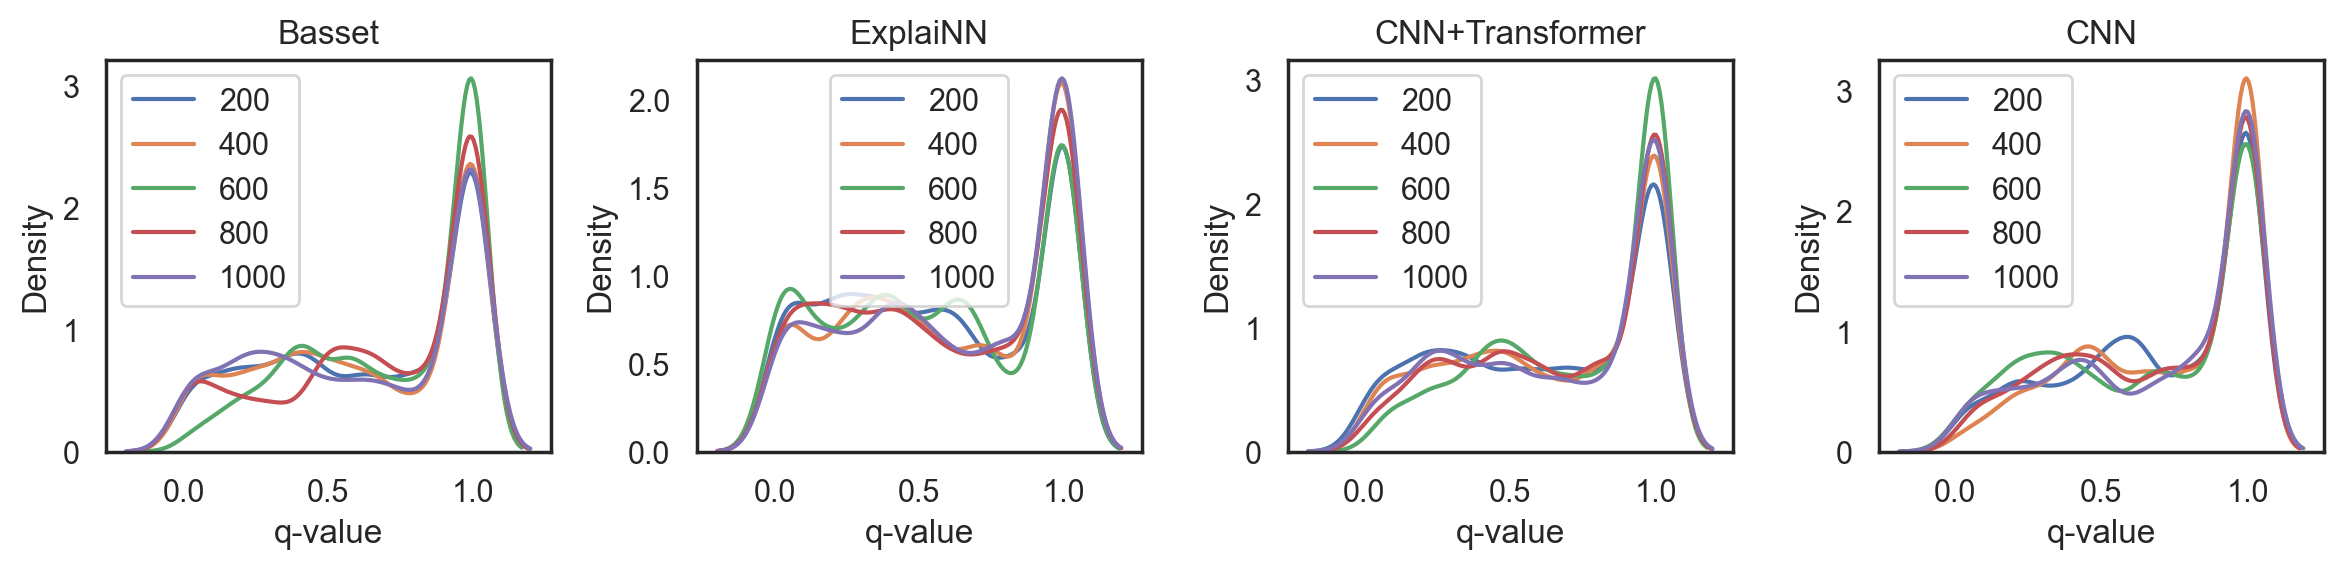

In [71]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), "legend.facecolor": "white"})

# 读取数据
df_basset_200 = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/meme/200/GM12878/exp/Basset/tomtom.tsv", sep="\t").iloc[0:-3, :]
df_basset_400 = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/meme/400/GM12878/exp/Basset/tomtom.tsv", sep="\t").iloc[0:-3, :]
df_basset_600 = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/meme/600/GM12878/exp/Basset/tomtom.tsv", sep="\t").iloc[0:-3, :]
df_basset_800 = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/meme/800/GM12878/exp/Basset/tomtom.tsv", sep="\t").iloc[0:-3, :]
df_basset_1000 = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/meme/1000/GM12878/exp/Basset/tomtom.tsv", sep="\t").iloc[0:-3, :]

df_danq_200 = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/meme/200/GM12878/exp/DanQ/tomtom.tsv", sep="\t").iloc[0:-3, :]
df_danq_400 = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/meme/400/GM12878/exp/DanQ/tomtom.tsv", sep="\t").iloc[0:-3, :]
df_danq_600 = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/meme/600/GM12878/exp/DanQ/tomtom.tsv", sep="\t").iloc[0:-3, :]
df_danq_800 = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/meme/800/GM12878/exp/DanQ/tomtom.tsv", sep="\t").iloc[0:-3, :]
df_danq_1000 = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/meme/1000/GM12878/exp/DanQ/tomtom.tsv", sep="\t").iloc[0:-3, :]

df_explainn_200 = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/meme/200/GM12878/exp/ExplaiNN/tomtom.tsv", sep="\t").iloc[0:-3, :]
df_explainn_400 = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/meme/400/GM12878/exp/ExplaiNN/tomtom.tsv", sep="\t").iloc[0:-3, :]
df_explainn_600 = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/meme/600/GM12878/exp/ExplaiNN/tomtom.tsv", sep="\t").iloc[0:-3, :]
df_explainn_800 = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/meme/800/GM12878/exp/ExplaiNN/tomtom.tsv", sep="\t").iloc[0:-3, :]
df_explainn_1000 = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/meme/1000/GM12878/exp/ExplaiNN/tomtom.tsv", sep="\t").iloc[0:-3, :]

df_cnn_transformer_200 = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/meme/200/GM12878/exp/CNN_Transformer/tomtom.tsv", sep="\t").iloc[0:-3, :]
df_cnn_transformer_400 = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/meme/400/GM12878/exp/CNN_Transformer/tomtom.tsv", sep="\t").iloc[0:-3, :]
df_cnn_transformer_600 = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/meme/600/GM12878/exp/CNN_Transformer/tomtom.tsv", sep="\t").iloc[0:-3, :]
df_cnn_transformer_800 = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/meme/800/GM12878/exp/CNN_Transformer/tomtom.tsv", sep="\t").iloc[0:-3, :]
df_cnn_transformer_1000 = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/meme/1000/GM12878/exp/CNN_Transformer/tomtom.tsv", sep="\t").iloc[0:-3, :]

df_cnn_200 = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/meme/200/GM12878/exp/CNN/tomtom.tsv", sep="\t").iloc[0:-3, :]
df_cnn_400 = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/meme/400/GM12878/exp/CNN/tomtom.tsv", sep="\t").iloc[0:-3, :]
df_cnn_600 = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/meme/600/GM12878/exp/CNN/tomtom.tsv", sep="\t").iloc[0:-3, :]
df_cnn_800 = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/meme/800/GM12878/exp/CNN/tomtom.tsv", sep="\t").iloc[0:-3, :]
df_cnn_1000 = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/meme/1000/GM12878/exp/CNN/tomtom.tsv", sep="\t").iloc[0:-3, :]

# Create a dictionary to store your dataframes
data = {
    "Basset": [df_basset_200, df_basset_400, df_basset_600, df_basset_800, df_basset_1000],
    "ExplaiNN": [df_explainn_200, df_explainn_400, df_explainn_600, df_explainn_800, df_explainn_1000],
    "CNN+Transformer": [df_cnn_transformer_200, df_cnn_transformer_400, df_cnn_transformer_600, df_cnn_transformer_800, df_cnn_transformer_1000],
    "CNN": [df_cnn_200, df_cnn_400, df_cnn_600, df_cnn_800, df_cnn_1000]
}

# Define a function to plot the density plots
def plot_density(data, column="q-value", save_path="density_plots.pdf"):
    plt.figure(figsize=(12, 3))  # Adjust figure size as needed

    for i, method in enumerate(data.keys()):
        plt.subplot(1, 4, i + 1)  # Create subplot for each method

        for j in range(5):  # Plot for each length (200, 400, etc.)
            sns.kdeplot(data[method][j][column], label=f"{200 * (j + 1)}")

        plt.title(method)
        plt.xlabel("q-value")
        plt.ylabel("Density")
        plt.legend()

    plt.tight_layout()
    plt.savefig(save_path, bbox_inches='tight')

# Call the function to create the plot
plot_density(data,save_path="/mnt/d/work/2023/1/NCBenchmark/Figure/Figure_fig/explainn/other_methods_q_value_density.pdf")

In [47]:
sns.kdeplot(df_basset["q-value"],fill=False,label="Basset")

,Query_ID,Target_ID,Optimal_offset,p-value,E-value,q-value,Overlap,Query_consensus,Target_consensus,Orientation,method,length
0,Motif_0,MA1580.1,-2.0,0.008052,6.771780,1.0,10.0,ACTCTACTGTGTTACTACT,TGTACAGTAT,+,Basset,200
1,Motif_1,MA0480.2,-1.0,0.001387,1.166570,1.0,11.0,CTCTGGTTAGACCAAGAAG,TCTGTTTACAT,-,Basset,200
2,Motif_1,MA0002.2,2.0,0.002829,2.379050,1.0,9.0,CTCTGGTTAGACCAAGAAG,GTCTGTGGTTT,+,Basset,200
3,Motif_1,MA0145.2,-2.0,0.003135,2.636840,1.0,14.0,CTCTGGTTAGACCAAGAAG,CTGGTTTGAACTGG,-,Basset,200
4,Motif_1,MA0593.1,-1.0,0.003833,3.223890,1.0,11.0,CTCTGGTTAGACCAAGAAG,TTTGTTTACTT,-,Basset,200
...,...,...,...,...,...,...,...,...,...,...,...,...
109239,Motif_298,MA0786.1,0.0,0.011531,9.697640,1.0,12.0,TATTGAACATAATTATTAT,TAATTTGCATAA,-,CNN,1000
109240,Motif_299,MA0896.1,0.0,0.000762,0.641011,1.0,17.0,CCGAACCCTGAATGCTTAT,ACAAGCAATTAATGAAT,+,CNN,1000
109241,Motif_299,MA0693.3,-7.0,0.002315,1.946620,1.0,11.0,CCGAACCCTGAATGCTTAT,CTGAGTTCATA,+,CNN,1000
109242,Motif_299,MA1588.1,0.0,0.006410,5.390420,1.0,15.0,CCGAACCCTGAATGCTTAT,GTCAACCAAGAATTC,-,CNN,1000


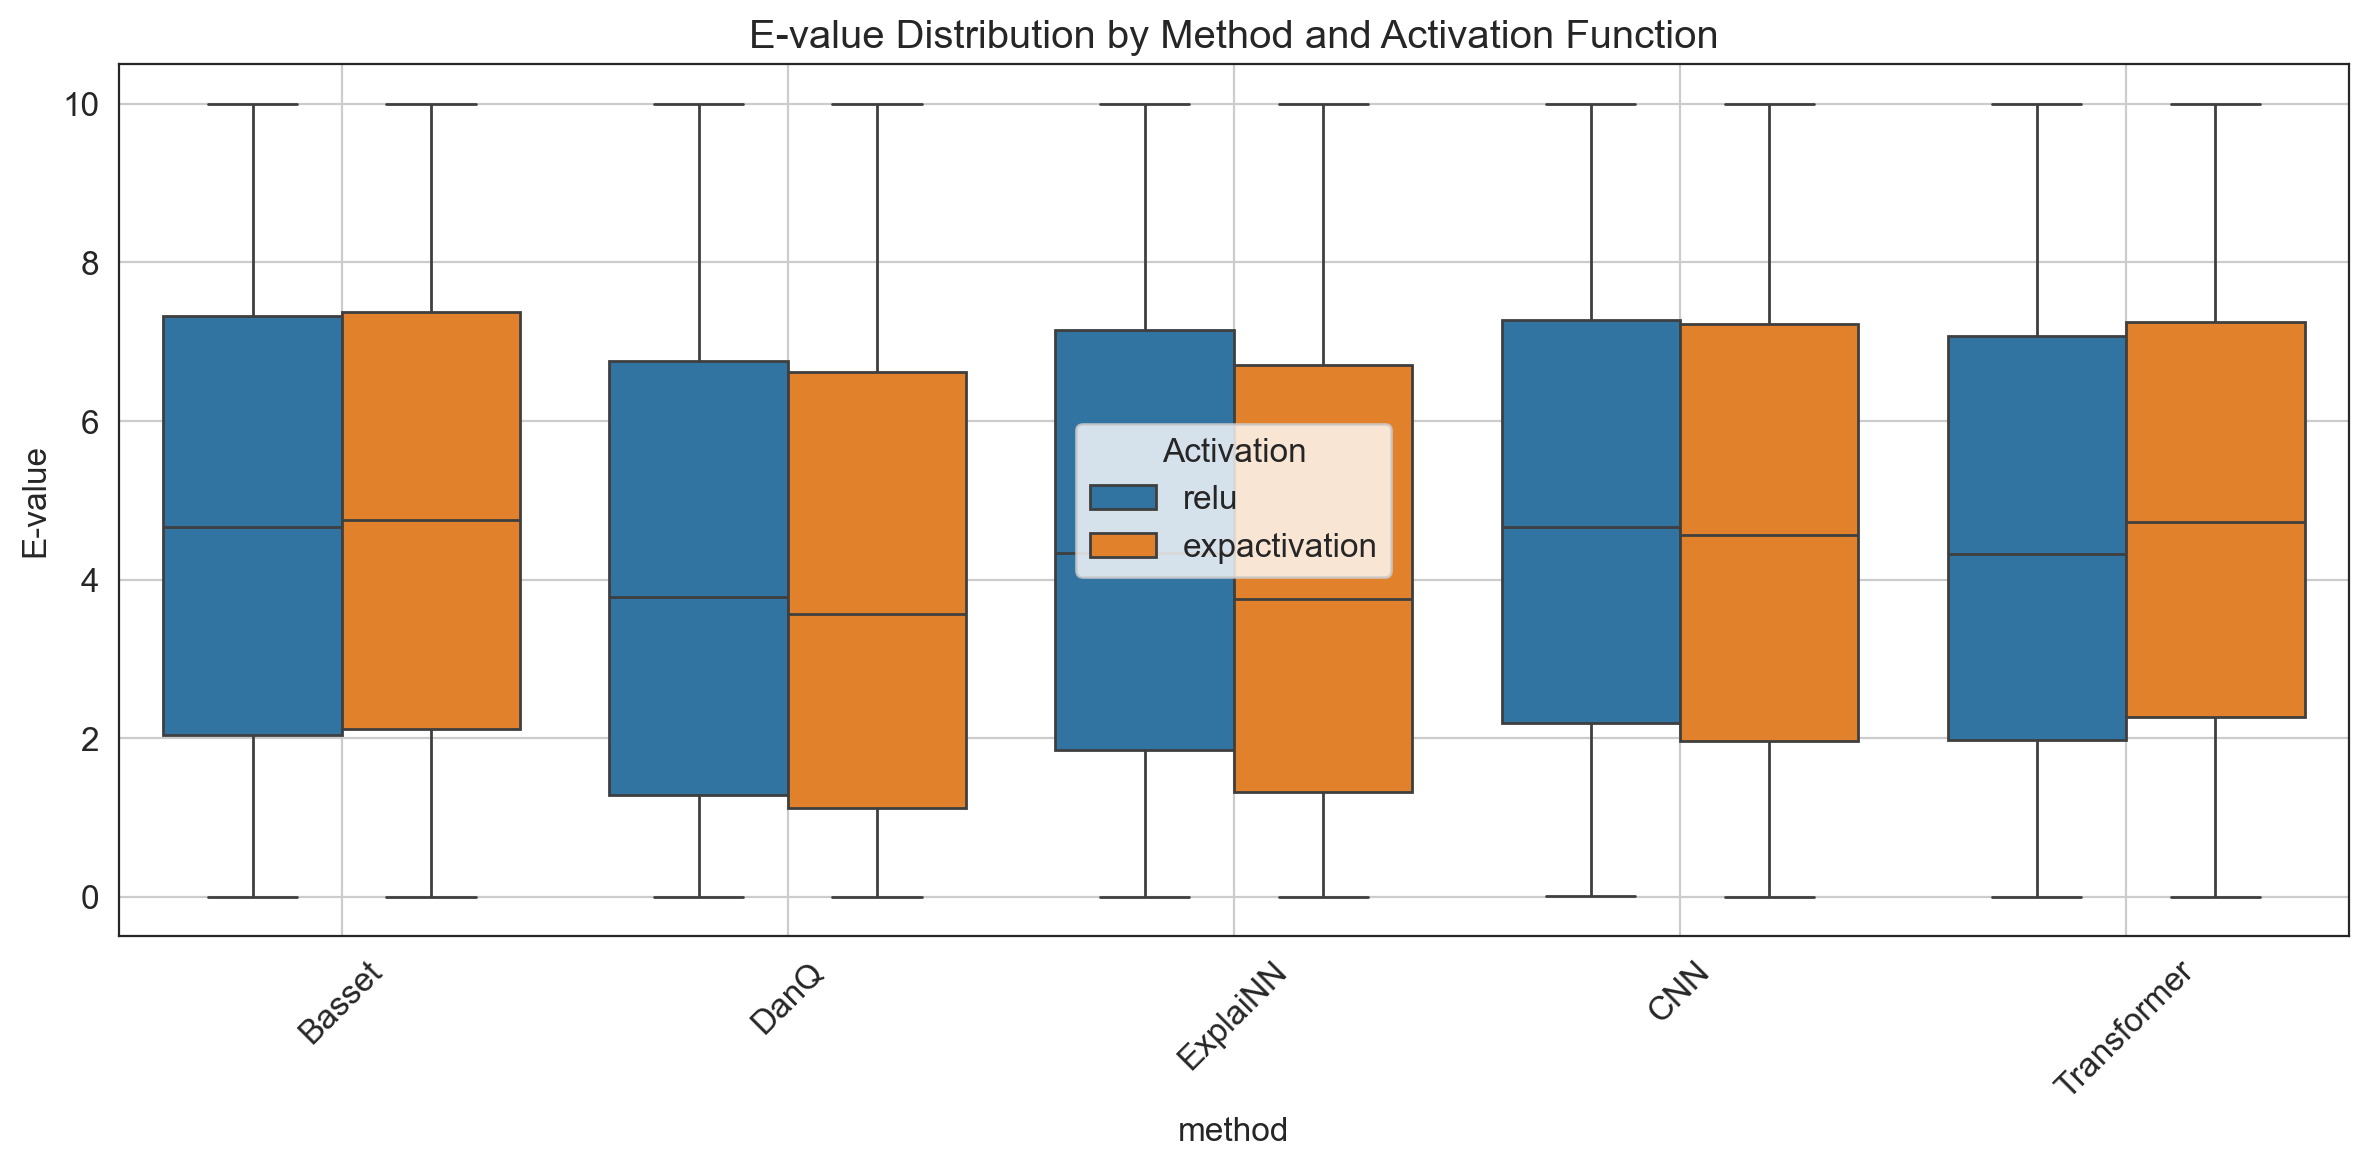

In [44]:
# #绘制不同方法E-value的小提琴图
# colors = sns.color_palette('Set2', 5)
# df_basset["method"] = "Basset"
# df_danq["method"] = "DanQ"
# df_explainn["method"] = "ExplaiNN"
# df_cnn["method"] = "CNN"
# df_cnn_transformer["method"] = "Transformer"
# df = pd.concat([df_basset,df_danq,df_explainn,df_cnn,df_cnn_transformer])

# df_basset_exp["method"] = "Basset"
# df_danq_exp["method"] = "DanQ"
# df_explainn_exp["method"] = "ExplaiNN"
# df_cnn_exp["method"] = "CNN"
# df_cnn_transformer_exp["method"] = "Transformer"
# df_exp = pd.concat([df_basset_exp,df_danq_exp,df_explainn_exp,df_cnn_exp,df_cnn_transformer_exp])

# plt.figure(figsize=(6,4))
# sns.boxplot(x="method",y="E-value",data=df,palette=colors,boxprops=dict(edgecolor="black",linewidth=1),capprops=dict(color="black", linewidth=1),medianprops=dict(color="black",linewidth=1),whiskerprops=dict(color="black",linewidth=1))
# sns.boxplot(x="method",y="E-value",data=df_exp,palette=colors,boxprops=dict(edgecolor="black",linewidth=1),capprops=dict(color="black", linewidth=1),medianprops=dict(color="black",linewidth=1),whiskerprops=dict(color="black",linewidth=1),showfliers=False)
# # plt.savefig("/mnt/d/work/2023/1/NCBenchmark/Figure/Figure_fig/explainn/e_value_boxplot.pdf",bbox_inches='tight')


```shell
for length in 200 400 600 800 1000; do
    for phase in "GM12878" "T-cell"; do
        for activate in "relu" "exp"; do
            for method in "Basset" "DanQ" "ExplaiNN" "CNN_Transformer" "CNN"; do
                tomtom -no-ssc /mnt/d/work/2023/1/NCBenchmark/meme/$length/motif_${phase}_${method}_${activate}.meme -verbosity 2 -min-overlap 5 -dist pearson -evalue -thresh 10.0 -oc /mnt/d/work/2023/1/NCBenchmark/meme/$length/$phase/$activate/$method -eps  /home/sun/software/meme/motif_databases.12.24/motif_databases/JASPAR/JASPAR2022_CORE_vertebrates_non-redundant_v2.meme &
            done
        done
    done
done

```


## 评估不同方法每个filter的重要性

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

fasta = pysam.FastaFile(fasta_paths["human"])

class BinaryDataset(Dataset):
    def __init__(self, data,label):
        self.data = data
        self.label = label

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx],self.label[idx]
    
# Create a custom collate function
def custom_collate_fn(batch):
    # 初始化序列和标签的列表
    sequences = []
    labels = []
    
    # 遍历batch中的每个(data, label)对
    for item in batch:
        # 假设 utils.onehot_seq 和 fasta.fetch 已经正确定义，并可以这样使用
        sequence = utils.onehot_seq(fasta.fetch(item[0][0], int(item[0][1]), int(item[0][2])).upper())
        sequences.append(sequence)
        labels.append(item[1])
    
    # 将序列和标签列表转换为张量
    sequences_tensor = torch.FloatTensor(np.array(sequences))
    labels_tensor = torch.FloatTensor(np.array(labels))
    
    return sequences_tensor, labels_tensor

class ExpActivation(nn.Module):
    """
    Exponential activation function from Koo & Ploenzke, 2021 (PMID: 34322657)
    """
    def __init__(self):
        super(ExpActivation, self).__init__()

    def forward(self, x):
        return torch.exp(x)

class Unsqueeze(torch.nn.Module):
    """
    Unsqueeze for sequential models
    """
    def forward(self, x):
        return x.unsqueeze(-1)

class Basset(nn.Module):
    def __init__(self, classes,linear_units,activate,*args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        if activate == 'relu':
            activation = nn.ReLU()
        elif activate == 'exp':
            activation = ExpActivation()

        self.net = nn.Sequential(
            nn.Conv1d(in_channels=4, out_channels=300, kernel_size=19, stride=1, padding=9),
            nn.BatchNorm1d(300),
            activation,
            nn.MaxPool1d(kernel_size=3, stride=2),
            nn.Conv1d(in_channels=300, out_channels=200, kernel_size=11, stride=1, padding=5),
            nn.BatchNorm1d(200),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=4, stride=2),
            nn.Conv1d(in_channels=200, out_channels=200, kernel_size=7, stride=1, padding=3),
            nn.BatchNorm1d(200),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=4, stride=2),
        )

        self.fc = nn.Sequential(
            nn.Linear(in_features=linear_units, out_features=1000),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(in_features=1000, out_features=1000),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(in_features=1000, out_features=classes)
        )

    def forward(self, x,filter_index=None):
        x = self.net[0](x)
        x = self.net[1](x)
        x = self.net[2](x)
        if filter_index is not None:
            x[:, filter_index, :] = 0
        x = self.net[3:](x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    

class DanQ(nn.Module):
    def __init__(self,classes,linear_units,activate,*args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        if activate == 'relu':
            activation = nn.ReLU()
        elif activate == 'exp':
            activation = ExpActivation()

        self.conv1d = nn.Sequential(
            nn.Conv1d(in_channels=4,out_channels=320,kernel_size=19,padding=9),
            activation,
            nn.MaxPool1d(kernel_size=13, stride=13),
            nn.Dropout(0.2)
        )
        self.lstm = nn.LSTM(input_size=320, hidden_size=320, num_layers=2, batch_first=True, bidirectional=True)

        self.fc = nn.Sequential(
            nn.Linear(linear_units, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, classes)
        )
    
    def forward(self, x,filter_index=None):
        out = self.conv1d(x)
        if filter_index is not None:
            out[:, filter_index, :] = 0
        out = out.permute(0,2,1)
        out,(hn,cn) = self.lstm(out)
        out = out.transpose(1,2)
        out = out.contiguous().view(x.size()[0],-1)
        out = self.fc(out)
        return out
    

class ExplaiNN(nn.Module):
    def __init__(self,classes, input_length,activate,num_cnns=300,*args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

        if activate == 'relu':
            activation = nn.ReLU()
        elif activate == 'exp':
            activation = ExpActivation()

        self.Conv1d = nn.Sequential(
                nn.Conv1d(in_channels=4, out_channels=num_cnns, kernel_size=19,padding=19//2),
                nn.BatchNorm1d(num_cnns),
                activation,
                nn.MaxPool1d(10),
                )
        self.Linear = nn.Sequential(
                nn.Flatten(),
                Unsqueeze(),
                nn.Conv1d(in_channels=int(input_length / 10)*num_cnns,
                          out_channels=100 * num_cnns, kernel_size=1,
                          groups=num_cnns),
                nn.BatchNorm1d(100 * num_cnns),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Conv1d(in_channels=100 * num_cnns,
                          out_channels=1 * num_cnns, kernel_size=1,
                          groups=num_cnns),
                nn.BatchNorm1d(1 * num_cnns),
                nn.ReLU(),
                nn.Flatten(),
        )

        self.classifier = nn.Linear(num_cnns,classes)

    def forward(self, x,filter_index=None):
        out = self.conv1d(x)
        if filter_index is not None:
            out[:, filter_index, :] = 0
        out = self.Linear(out)
        out1 = self.classifier(out)
        return out1
    
class CNN_Transformer(nn.Module):
    def __init__(self,classes,linear_units,activate, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

        if activate == 'relu':
            activation = nn.ReLU()
        elif activate == 'exp':
            activation = ExpActivation()

        self.conv1d = nn.Sequential(
            nn.Conv1d(in_channels=4, out_channels=300, kernel_size=19, padding=9),
            nn.BatchNorm1d(300),
            activation,
            nn.MaxPool1d(kernel_size=10),
            nn.Dropout(0.2)
        )
        self.transformer = nn.TransformerEncoderLayer(d_model=300,nhead=6)

        self.fc = nn.Sequential(
            nn.Linear(linear_units, 925),
            nn.ReLU(),
            nn.Linear(925, classes)
        )

    def forward(self, x,filter_index=None):
        out = self.conv1d(x)
        if filter_index is not None:
            out[:, filter_index, :] = 0
        out = out.permute(0,2,1)
        x = self.transformer(out)

        out = x.contiguous().view(x.size()[0],-1)
        out = self.fc(out)
        return out
    

class CNN(nn.Module):
    def __init__(self, classes, linear_units,activate) -> None:
        super(CNN, self).__init__()

        if activate == 'relu':
            activation = nn.ReLU()
        elif activate == 'exp':
            activation = ExpActivation()

        self.conv1d = nn.Sequential(
            nn.Conv1d(in_channels=4, out_channels=300, kernel_size=19, padding=9),
            nn.BatchNorm1d(300),
            activation,
            nn.MaxPool1d(6, 6),
        )
        self.dense = nn.Sequential(
            nn.Linear(linear_units, 300),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(300, classes),
        )


    def forward(self, x,filter_index=None):
        out = self.conv1d(x)
        if filter_index is not None:
            out[:, filter_index, :] = 0
        out1 = out.contiguous().view(x.size()[0], -1)
        out = self.dense(out1)
        return out

300

In [49]:
length = 600
phase = "GM12878"
activate = "relu"

data_path = f"/mnt/d/work/2023/1/NCBenchmark/data/{phase}/train_test_{length}.npz"
data_ = np.load(data_path)
val_dataset = BinaryDataset(data_["test_data"],data_["test_label"])
val_loader = DataLoader(val_dataset, batch_size=int(128), shuffle=False,collate_fn=custom_collate_fn,num_workers=8)

filter_inportance = {}
for method in ["Basset","DanQ","CNN_Transformer","CNN"]:
    filter_inportance[method] = []
for method in ["Basset","DanQ","CNN_Transformer","CNN"]:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = eval(f'{method}(1, linear_units_dict["{method}"]["{length}bp"], activate="{activate}")')
    model.load_state_dict(torch.load(f"/mnt/d/work/2023/1/NCBenchmark/train_results/{phase}/{method}_40_{length}_{activate}_best_network.pth",map_location=device))
    model.to(device)
    model.eval()
    method_out = []
    original_out = []
    original_label = []
    for x,y in val_loader:
        x = x.float().to(device).transpose(2,1)
        out = model(x)
        out = F.sigmoid(out)
        original_out.extend(out.cpu().detach().numpy())
        original_label.extend(y.cpu().detach().numpy())
    original_out = np.array(original_out)
    original_label = np.array(original_label)
    #挑选原始label为1的样本
    original_out = original_out[original_label==1]
    original_out_mean = original_out.mean()
    pbar = tqdm(range(next(model.children())[0].weight.data.shape[0]))
    start = time.time()
    for filter_index in pbar:
        pbar.set_description(f"method:{method} filter_index:{filter_index}")
        mask_filter = []
        for x,y in val_loader:
            x = x.float().to(device).transpose(2,1)
            out = model(x,filter_index=filter_index)
            out = F.sigmoid(out)
            mask_filter.extend(out.cpu().detach().numpy())
        mask_filter = np.array(mask_filter)
        mask_filter = mask_filter[original_label==1]
        mask_filter_mean = mask_filter.mean()
        method_out.append(round(mask_filter_mean - original_out_mean,3))
    filter_inportance[method].extend(method_out)
    end = time.time()
    print(f"Training time: {end-start}s")

method:Basset filter_index:299: 100%|██████████| 300/300 [12:15<00:00,  2.45s/it]


Training time: 735.5137553215027s


method:DanQ filter_index:319: 100%|██████████| 320/320 [18:37<00:00,  3.49s/it]


Training time: 1117.8438394069672s


method:CNN_Transformer filter_index:299: 100%|██████████| 300/300 [12:45<00:00,  2.55s/it]


Training time: 765.7899324893951s


method:CNN filter_index:299: 100%|██████████| 300/300 [10:08<00:00,  2.03s/it]

Training time: 608.978401184082s


In [55]:
pd.DataFrame.from_dict(filter_inportance,orient='index').transpose().to_csv(f"/mnt/d/work/2023/1/NCBenchmark/meme/600/{phase}_{length}_{activate}.csv",index=False)

### 评估回归方法的解释性

In [32]:
fasta = pysam.FastaFile(fasta_paths["human"])
for length in [200,400,600,800,1000]:
    for phase in ["GM12878","T-cell"]:
        for activate in ["exp"]:
            for method in ["Basset","DanQ","ExplaiNN","CNN_Transformer","CNN"]:
                device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
                model = eval(f'models.{method}(1, linear_units_dict["{method}"]["{length}bp"], activate="{activate}")')
                model.load_state_dict(torch.load(f"/mnt/d/work/2023/1/NCBenchmark/train_results/{phase}/{method}_40_{length}_relu_repression_mse_best_network.pth",map_location=device))
                model.to(device)
                model.eval()

                data_path = f"/mnt/d/work/2023/1/NCBenchmark/data/{phase}/train_data_{length}_reads.npz"
                data_ = np.load(data_path,allow_pickle=True)
                val_dataset = BinaryDataset(data_["test_data"][0:2000])
                val_loader = DataLoader(val_dataset, batch_size=int(128), shuffle=False, collate_fn=get_custom_collate_fn(fasta),num_workers=10)
                fmap,X = get_fmap(model,next(model.children())[0],val_loader,device=device)
                W,seq_ls = get_activate_W_from_fmap(fmap,X,threshold=0.85,motif_width=17,padding=9)
                motif_ic = []
                for i in range(len(W)):
                    ic = calc_motif_IC(W[i])
                    motif_ic.append(ic)
                motif_ic_df = pd.DataFrame(motif_ic)
                motif_ic_df.to_csv(f"/mnt/d/work/2023/1/NCBenchmark/meme/repression/{length}/motif_ic_{phase}_{method}_{activate}.csv",index=False,header=False)
                meme_generate(W,output_file=f"/mnt/d/work/2023/1/NCBenchmark/meme/repression/{length}/motif_{phase}_{method}_{activate}.meme")

In [56]:
#评估不同方法发现motif的能力
df_basset = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/meme/repression/600/GM12878/relu/Basset/tomtom.tsv",sep="\t").iloc[0:-3,:]
df_danq = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/meme/repression/600/GM12878/relu/DanQ/tomtom.tsv",sep="\t").iloc[0:-3,:]
df_explainn = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/meme/repression/600/GM12878/relu/ExplaiNN/tomtom.tsv",sep="\t").iloc[0:-3,:]
df_cnn = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/meme/repression/600/GM12878/relu/CNN/tomtom.tsv",sep="\t").iloc[0:-3,:]
df_cnn_transformer = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/meme/repression/600/GM12878/relu/CNN_Transformer/tomtom.tsv",sep="\t").iloc[0:-3,:]

df_basset_exp = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/meme/repression/600/GM12878/exp/Basset/tomtom.tsv",sep="\t").iloc[0:-3,:]
df_danq_exp = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/meme/repression/600/GM12878/exp/DanQ/tomtom.tsv",sep="\t").iloc[0:-3,:]
df_explainn_exp = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/meme/repression/600/GM12878/exp/ExplaiNN/tomtom.tsv",sep="\t").iloc[0:-3,:]
df_cnn_exp = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/meme/repression/600/GM12878/exp/CNN/tomtom.tsv",sep="\t").iloc[0:-3,:]
df_cnn_transformer_exp = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/meme/repression/600/GM12878/exp/CNN_Transformer/tomtom.tsv",sep="\t").iloc[0:-3,:]

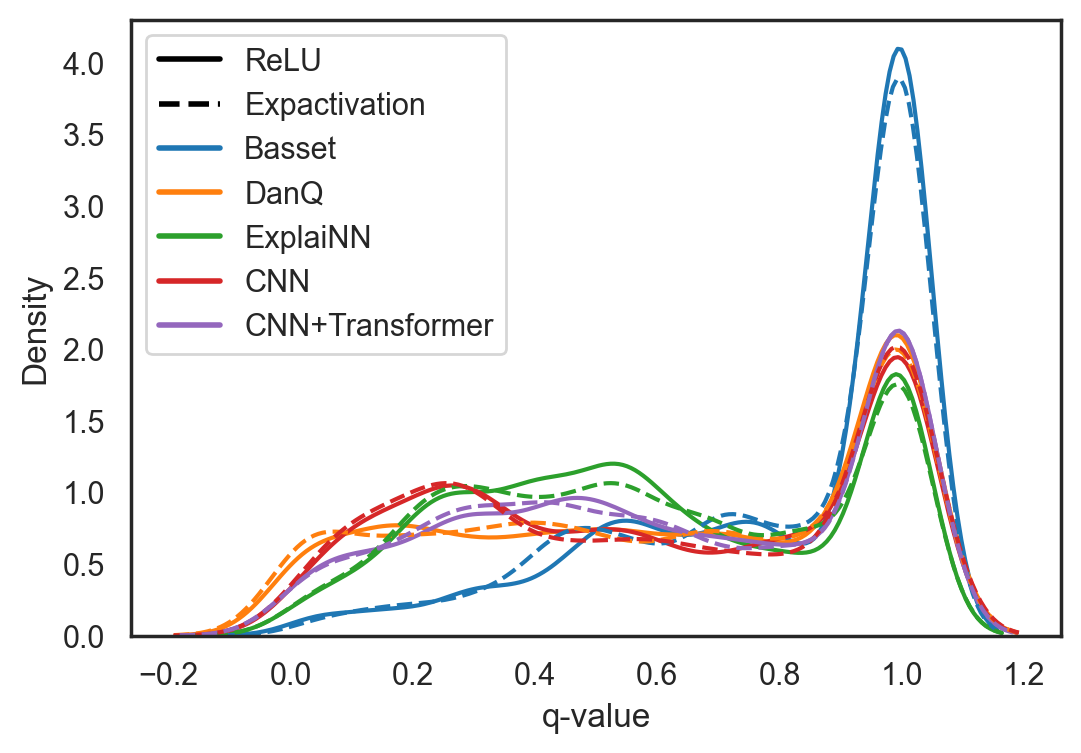

In [57]:
# 设置颜色
palette = sns.color_palette("tab10")

# 绘制KDE图
plt.figure(figsize=(6, 4))

sns.kdeplot(df_basset["q-value"], fill=False, label="Basset (ReLU)", color=palette[0])
sns.kdeplot(df_danq["q-value"], fill=False, label="DanQ (ReLU)", color=palette[1])
sns.kdeplot(df_explainn["q-value"], fill=False, label="ExplaiNN (ReLU)", color=palette[2])
sns.kdeplot(df_cnn["q-value"], fill=False, label="CNN (ReLU)", color=palette[3])
sns.kdeplot(df_cnn_transformer["q-value"], fill=False, label="CNN+Transformer (ReLU)", color=palette[4])

sns.kdeplot(df_basset_exp["q-value"], fill=False, label="Basset (Exp)", color=palette[0], linestyle='--')
sns.kdeplot(df_danq_exp["q-value"], fill=False, label="DanQ (Exp)", color=palette[1], linestyle='--')
sns.kdeplot(df_explainn_exp["q-value"], fill=False, label="ExplaiNN (Exp)", color=palette[2], linestyle='--')
sns.kdeplot(df_cnn_exp["q-value"], fill=False, label="CNN (Exp)", color=palette[3], linestyle='--')
sns.kdeplot(df_cnn_transformer_exp["q-value"], fill=False, label="CNN+Transformer (Exp)", color=palette[4], linestyle='--')

# 自定义图例
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color="black", lw=2, label='ReLU'),
    Line2D([0], [0], color="black", lw=2, linestyle='--', label='Expactivation'),
    Line2D([0], [0], color=palette[0], lw=2, label='Basset'),
    Line2D([0], [0], color=palette[1], lw=2, label='DanQ'),
    Line2D([0], [0], color=palette[2], lw=2, label='ExplaiNN'),
    Line2D([0], [0], color=palette[3], lw=2, label='CNN'),
    Line2D([0], [0], color=palette[4], lw=2, label='CNN+Transformer'),
]

plt.legend(handles=legend_elements)
plt.savefig()

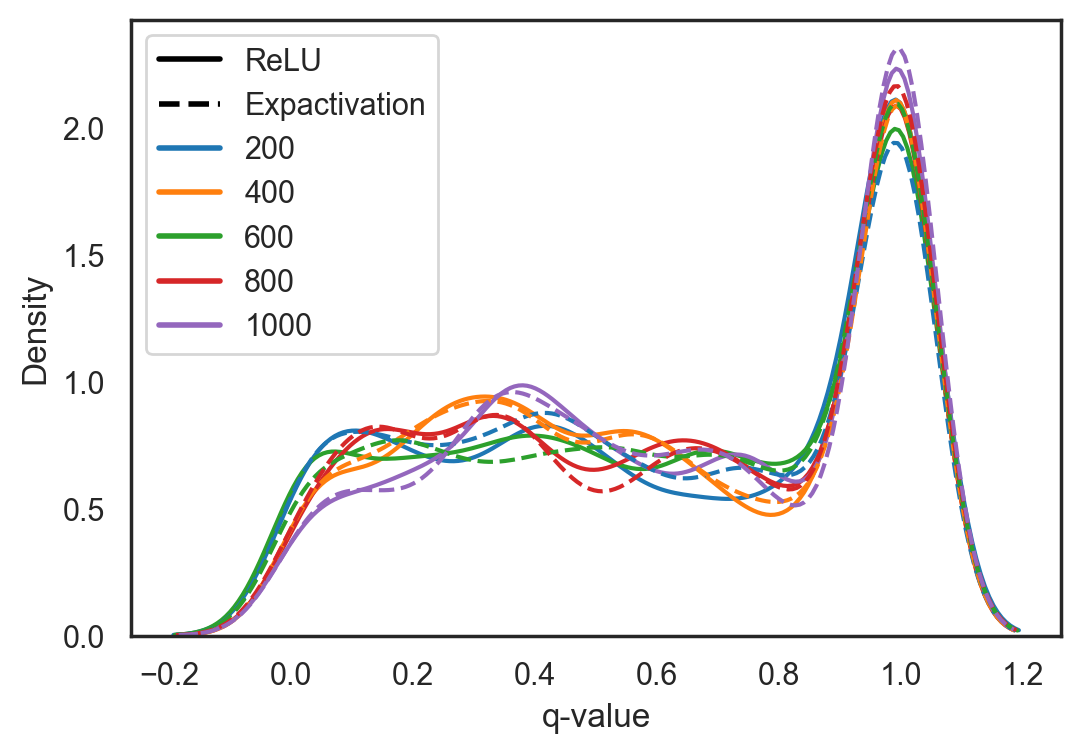

In [68]:
palette = sns.color_palette("tab10")

df_danq_200 = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/meme/repression/200/GM12878/exp/DanQ/tomtom.tsv",sep="\t").iloc[0:-3,:]
df_danq_400 = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/meme/repression/400/GM12878/exp/DanQ/tomtom.tsv",sep="\t").iloc[0:-3,:]
df_danq_600 = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/meme/repression/600/GM12878/exp/DanQ/tomtom.tsv",sep="\t").iloc[0:-3,:]
df_danq_800 = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/meme/repression/800/GM12878/exp/DanQ/tomtom.tsv",sep="\t").iloc[0:-3,:]
df_danq_1000 = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/meme/repression/1000/GM12878/exp/DanQ/tomtom.tsv",sep="\t").iloc[0:-3,:]

df_danq_200_relu = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/meme/repression/200/GM12878/relu/DanQ/tomtom.tsv",sep="\t").iloc[0:-3,:]
df_danq_400_relu = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/meme/repression/400/GM12878/relu/DanQ/tomtom.tsv",sep="\t").iloc[0:-3,:]
df_danq_600_relu = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/meme/repression/600/GM12878/relu/DanQ/tomtom.tsv",sep="\t").iloc[0:-3,:]
df_danq_800_relu = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/meme/repression/800/GM12878/relu/DanQ/tomtom.tsv",sep="\t").iloc[0:-3,:]
df_danq_1000_relu = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/meme/repression/1000/GM12878/relu/DanQ/tomtom.tsv",sep="\t").iloc[0:-3,:]

plt.figure(figsize=(6,4))
sns.kdeplot(df_danq_200["q-value"],label="200", color=palette[0])
sns.kdeplot(df_danq_400["q-value"],label="400",color=palette[1])
sns.kdeplot(df_danq_600["q-value"],label="600",color=palette[2])
sns.kdeplot(df_danq_800["q-value"],label="800",color=palette[3])
sns.kdeplot(df_danq_1000["q-value"],label="1000",color=palette[4])


sns.kdeplot(df_danq_200_relu["q-value"],label="200",color=palette[0], linestyle='--')
sns.kdeplot(df_danq_400_relu["q-value"],label="400",color=palette[1], linestyle='--')
sns.kdeplot(df_danq_600_relu["q-value"],label="600",color=palette[2], linestyle='--')
sns.kdeplot(df_danq_800_relu["q-value"],label="800",color=palette[3], linestyle='--')
sns.kdeplot(df_danq_1000_relu["q-value"],label="1000",color=palette[4], linestyle='--')

from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color="black", lw=2, label='ReLU'),
    Line2D([0], [0], color="black", lw=2, linestyle='--', label='Expactivation'),
    Line2D([0], [0], color=palette[0], lw=2, label='200'),
    Line2D([0], [0], color=palette[1], lw=2, label='400'),
    Line2D([0], [0], color=palette[2], lw=2, label='600'),
    Line2D([0], [0], color=palette[3], lw=2, label='800'),
    Line2D([0], [0], color=palette[4], lw=2, label='1000'),
]

plt.legend(handles=legend_elements)
# plt.savefig("/mnt/d/work/2023/1/NCBenchmark/Figure/Figure_fig/explainn/q_value_density_length_DanQ_repression_exp.pdf",bbox_inches='tight')

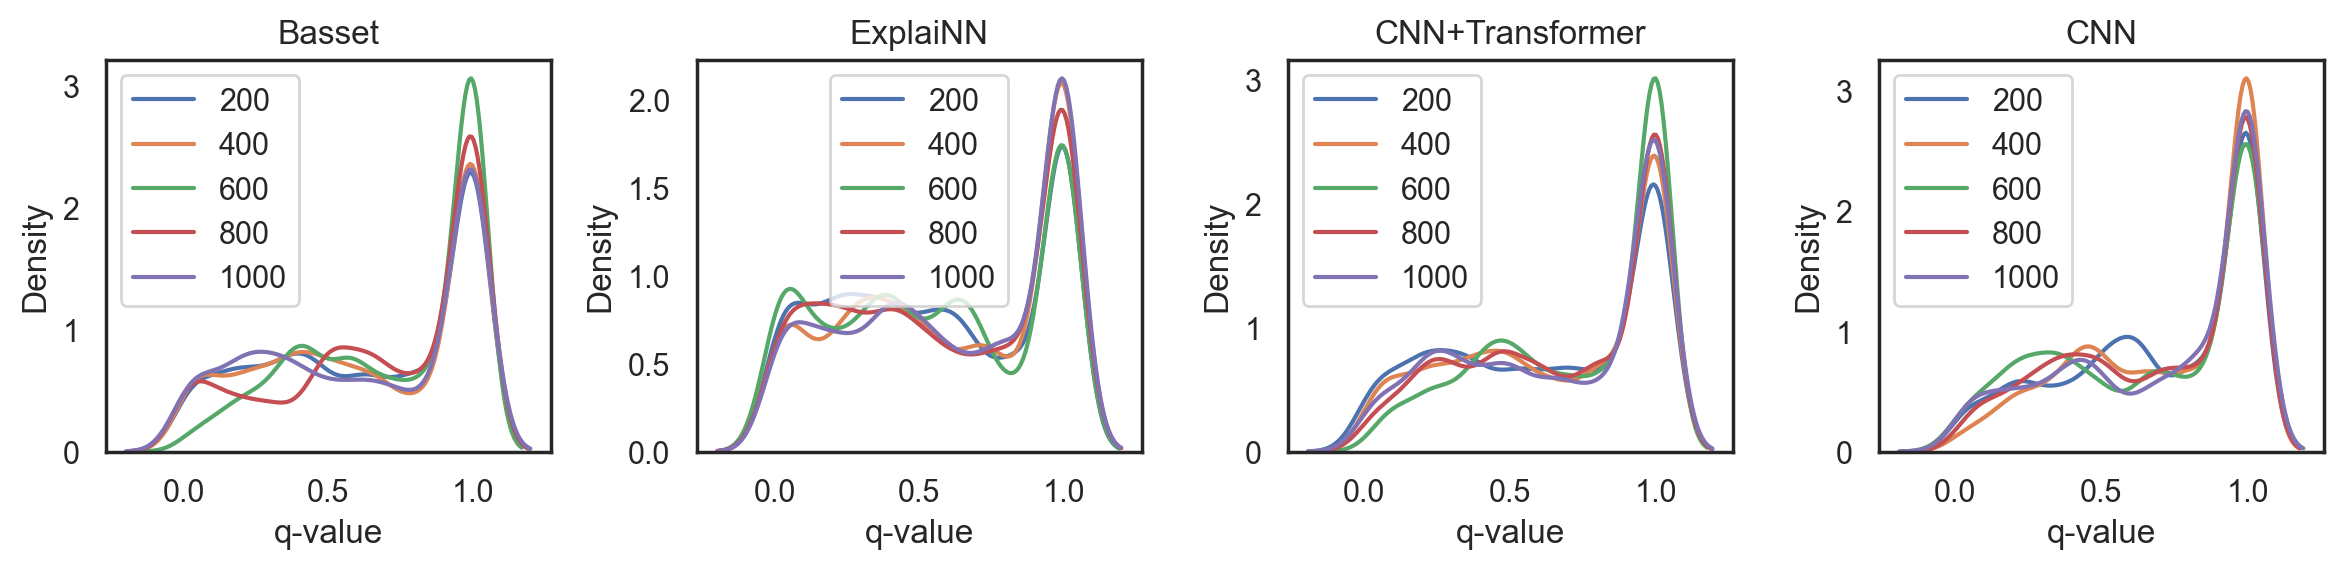

In [70]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), "legend.facecolor": "white"})

# 读取数据
df_basset_200 = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/meme/200/GM12878/exp/Basset/tomtom.tsv", sep="\t").iloc[0:-3, :]
df_basset_400 = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/meme/400/GM12878/exp/Basset/tomtom.tsv", sep="\t").iloc[0:-3, :]
df_basset_600 = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/meme/600/GM12878/exp/Basset/tomtom.tsv", sep="\t").iloc[0:-3, :]
df_basset_800 = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/meme/800/GM12878/exp/Basset/tomtom.tsv", sep="\t").iloc[0:-3, :]
df_basset_1000 = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/meme/1000/GM12878/exp/Basset/tomtom.tsv", sep="\t").iloc[0:-3, :]

# df_danq_200 = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/meme/200/GM12878/exp/DanQ/tomtom.tsv", sep="\t").iloc[0:-3, :]
# df_danq_400 = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/meme/400/GM12878/exp/DanQ/tomtom.tsv", sep="\t").iloc[0:-3, :]
# df_danq_600 = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/meme/600/GM12878/exp/DanQ/tomtom.tsv", sep="\t").iloc[0:-3, :]
# df_danq_800 = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/meme/800/GM12878/exp/DanQ/tomtom.tsv", sep="\t").iloc[0:-3, :]
# df_danq_1000 = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/meme/1000/GM12878/exp/DanQ/tomtom.tsv", sep="\t").iloc[0:-3, :]

df_explainn_200 = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/meme/200/GM12878/exp/ExplaiNN/tomtom.tsv", sep="\t").iloc[0:-3, :]
df_explainn_400 = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/meme/400/GM12878/exp/ExplaiNN/tomtom.tsv", sep="\t").iloc[0:-3, :]
df_explainn_600 = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/meme/600/GM12878/exp/ExplaiNN/tomtom.tsv", sep="\t").iloc[0:-3, :]
df_explainn_800 = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/meme/800/GM12878/exp/ExplaiNN/tomtom.tsv", sep="\t").iloc[0:-3, :]
df_explainn_1000 = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/meme/1000/GM12878/exp/ExplaiNN/tomtom.tsv", sep="\t").iloc[0:-3, :]

df_cnn_transformer_200 = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/meme/200/GM12878/exp/CNN_Transformer/tomtom.tsv", sep="\t").iloc[0:-3, :]
df_cnn_transformer_400 = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/meme/400/GM12878/exp/CNN_Transformer/tomtom.tsv", sep="\t").iloc[0:-3, :]
df_cnn_transformer_600 = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/meme/600/GM12878/exp/CNN_Transformer/tomtom.tsv", sep="\t").iloc[0:-3, :]
df_cnn_transformer_800 = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/meme/800/GM12878/exp/CNN_Transformer/tomtom.tsv", sep="\t").iloc[0:-3, :]
df_cnn_transformer_1000 = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/meme/1000/GM12878/exp/CNN_Transformer/tomtom.tsv", sep="\t").iloc[0:-3, :]

df_cnn_200 = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/meme/200/GM12878/exp/CNN/tomtom.tsv", sep="\t").iloc[0:-3, :]
df_cnn_400 = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/meme/400/GM12878/exp/CNN/tomtom.tsv", sep="\t").iloc[0:-3, :]
df_cnn_600 = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/meme/600/GM12878/exp/CNN/tomtom.tsv", sep="\t").iloc[0:-3, :]
df_cnn_800 = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/meme/800/GM12878/exp/CNN/tomtom.tsv", sep="\t").iloc[0:-3, :]
df_cnn_1000 = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/meme/1000/GM12878/exp/CNN/tomtom.tsv", sep="\t").iloc[0:-3, :]

# Create a dictionary to store your dataframes
data = {
    "Basset": [df_basset_200, df_basset_400, df_basset_600, df_basset_800, df_basset_1000],
    "ExplaiNN": [df_explainn_200, df_explainn_400, df_explainn_600, df_explainn_800, df_explainn_1000],
    "CNN+Transformer": [df_cnn_transformer_200, df_cnn_transformer_400, df_cnn_transformer_600, df_cnn_transformer_800, df_cnn_transformer_1000],
    "CNN": [df_cnn_200, df_cnn_400, df_cnn_600, df_cnn_800, df_cnn_1000]
}

# Define a function to plot the density plots
def plot_density(data, column="q-value", save_path="density_plots.pdf"):
    plt.figure(figsize=(12, 3))  # Adjust figure size as needed

    for i, method in enumerate(data.keys()):
        plt.subplot(1, 4, i + 1)  # Create subplot for each method

        for j in range(5):  # Plot for each length (200, 400, etc.)
            sns.kdeplot(data[method][j][column], label=f"{200 * (j + 1)}")

        plt.title(method)
        plt.xlabel("q-value")
        plt.ylabel("Density")
        plt.legend()

    plt.tight_layout()
    plt.savefig(save_path, bbox_inches='tight')

# Call the function to create the plot
plot_density(data,save_path="/mnt/d/work/2023/1/NCBenchmark/Figure/Figure_fig/explainn/other_methods_q_value_density_repression_exp.pdf")


In [88]:
#绘制不同方法的IC箱线图
df_basset_ic_600 = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/meme/200/motif_ic_GM12878_Basset_exp.csv",header=None)
df_danq_ic_600 = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/meme/200/motif_ic_GM12878_DanQ_exp.csv",header=None)
df_explainn_ic_600 = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/meme/200/motif_ic_GM12878_ExplaiNN_exp.csv",header=None)
df_cnn_ic_600 = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/meme/200/motif_ic_GM12878_CNN_exp.csv",header=None)
df_cnn_transformer_ic_600 = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/meme/200/motif_ic_GM12878_CNN_Transformer_exp.csv",header=None)

df_basset_ic_600["method"] = "Basset"
df_danq_ic_600["method"] = "DanQ"
df_explainn_ic_600["method"] = "ExplaiNN"
df_cnn_ic_600["method"] = "CNN"
df_cnn_transformer_ic_600["method"] = "CNN+Transformer"

In [89]:
df_ic = pd.concat([df_basset_ic_600,df_danq_ic_600,df_explainn_ic_600,df_cnn_ic_600,df_cnn_transformer_ic_600])
df_ic.columns = ["IC","method"]

/tmp/ipykernel_3897601/3063842542.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(df_ic,x="method",y="IC",palette=colors,boxprops=dict(edgecolor="black",linewidth=1),capprops=dict(color="black", linewidth=1),medianprops=dict(color="black",linewidth=1),whiskerprops=dict(color="black",linewidth=1))


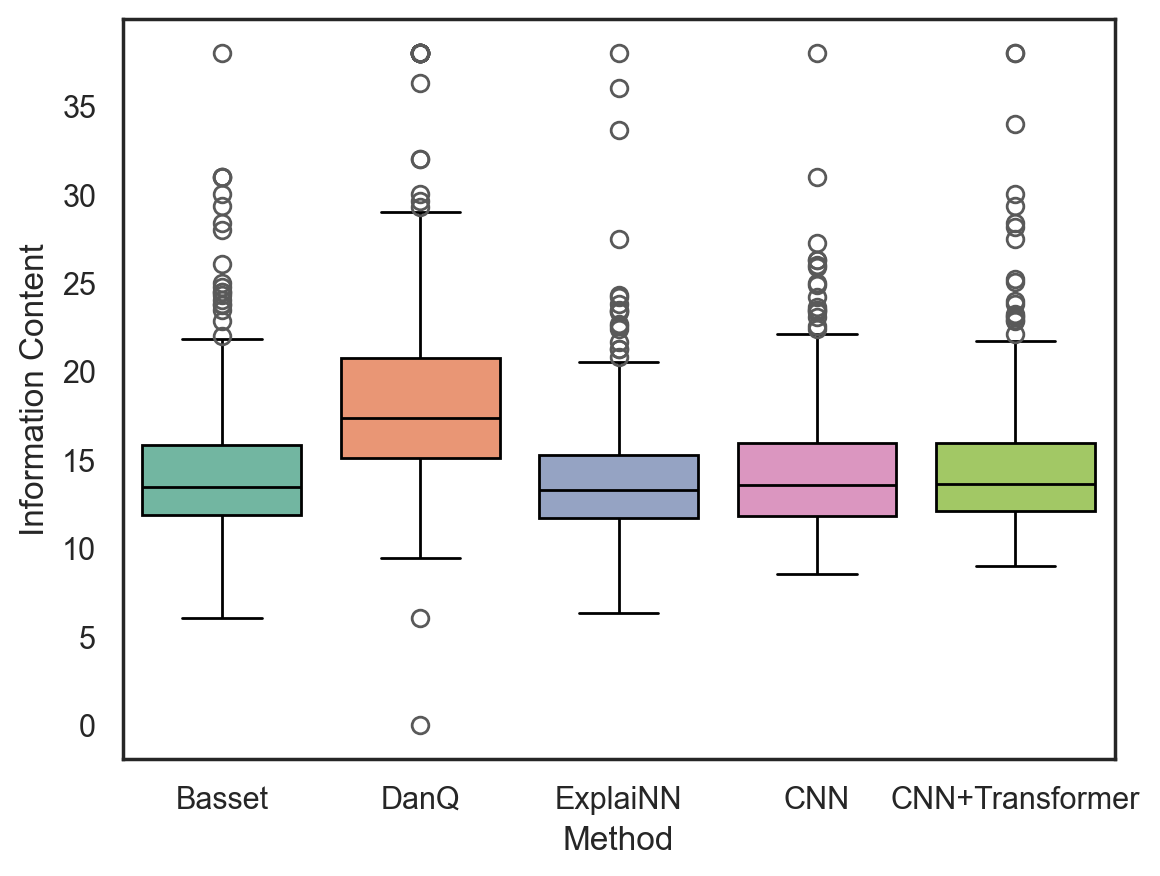

In [96]:
colors = sns.color_palette('Set2', 5)
sns.boxplot(df_ic,x="method",y="IC",palette=colors,boxprops=dict(edgecolor="black",linewidth=1),capprops=dict(color="black", linewidth=1),medianprops=dict(color="black",linewidth=1),whiskerprops=dict(color="black",linewidth=1))
plt.xlabel("Method")
plt.ylabel("Information Content")
plt.savefig("/mnt/d/work/2023/1/NCBenchmark/Figure/Figure_fig/explainn/Information_Content.pdf",bbox_inches='tight')

In [99]:
df_important_filter = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/meme/600/GM12878_600_relu.csv")

In [101]:
df_important_filter["DanQ"].sort_values(ascending=False).head(10)

163    0.015
21     0.015
56     0.011
1      0.009
62     0.008
253    0.008
201    0.007
119    0.007
176    0.007
184    0.007
Name: DanQ, dtype: float64

In [125]:
method = "ExplaiNN"
phase = "GM12878"
length = 600
activate = "exp"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = eval(f'models.{method}(1, linear_units_dict["{method}"]["{length}bp"], activate="{activate}")')
model.load_state_dict(torch.load(f"/mnt/d/work/2023/1/NCBenchmark/train_results/{phase}/{method}_40_{length}_{activate}_best_network.pth",map_location=device))
model.to(device)
model.eval()

ExplaiNN(
  (Conv1d): Sequential(
    (0): Conv1d(4, 300, kernel_size=(19,), stride=(1,), padding=(9,))
    (1): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ExpActivation()
    (3): MaxPool1d(kernel_size=10, stride=10, padding=0, dilation=1, ceil_mode=False)
  )
  (Linear): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Unsqueeze()
    (2): Conv1d(18000, 30000, kernel_size=(1,), stride=(1,), groups=300)
    (3): BatchNorm1d(30000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Conv1d(30000, 300, kernel_size=(1,), stride=(1,), groups=300)
    (7): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Flatten(start_dim=1, end_dim=-1)
  )
  (classifier): Linear(in_features=300, out_features=1, bias=True)
)

In [129]:
pd.DataFrame(model.classifier.weight.data.cpu().numpy().reshape(-1)).sort_values(by=0,ascending=False).head(15)

,0
158,0.511727
228,0.400594
60,0.324373
256,0.278602
54,0.270022
162,0.263127
221,0.259872
193,0.247381
191,0.239265
154,0.236392


In [123]:
method = "ExplaiNN"
phase = "GM12878"
length = 600
activate = "exp"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = eval(f'models.{method}(1, linear_units_dict["{method}"]["{length}bp"], activate="{activate}")')
model.load_state_dict(torch.load(f"/mnt/d/work/2023/1/NCBenchmark/train_results/GM12878/ExplaiNN_40_600_relu_repression_mse_best_network.pth",map_location=device))
model.to(device)
model.eval()

ExplaiNN(
  (Conv1d): Sequential(
    (0): Conv1d(4, 300, kernel_size=(19,), stride=(1,), padding=(9,))
    (1): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ExpActivation()
    (3): MaxPool1d(kernel_size=10, stride=10, padding=0, dilation=1, ceil_mode=False)
  )
  (Linear): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Unsqueeze()
    (2): Conv1d(18000, 30000, kernel_size=(1,), stride=(1,), groups=300)
    (3): BatchNorm1d(30000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Conv1d(30000, 300, kernel_size=(1,), stride=(1,), groups=300)
    (7): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Flatten(start_dim=1, end_dim=-1)
  )
  (classifier): Linear(in_features=300, out_features=1, bias=True)
)

In [124]:
pd.DataFrame(model.classifier.weight.data.cpu().numpy().reshape(-1)).sort_values(by=0,ascending=False).head(10)

,0
99,0.320095
106,0.315527
298,0.314069
279,0.309640
38,0.306854
270,0.305059
257,0.302865
149,0.300884
156,0.299872
100,0.296533


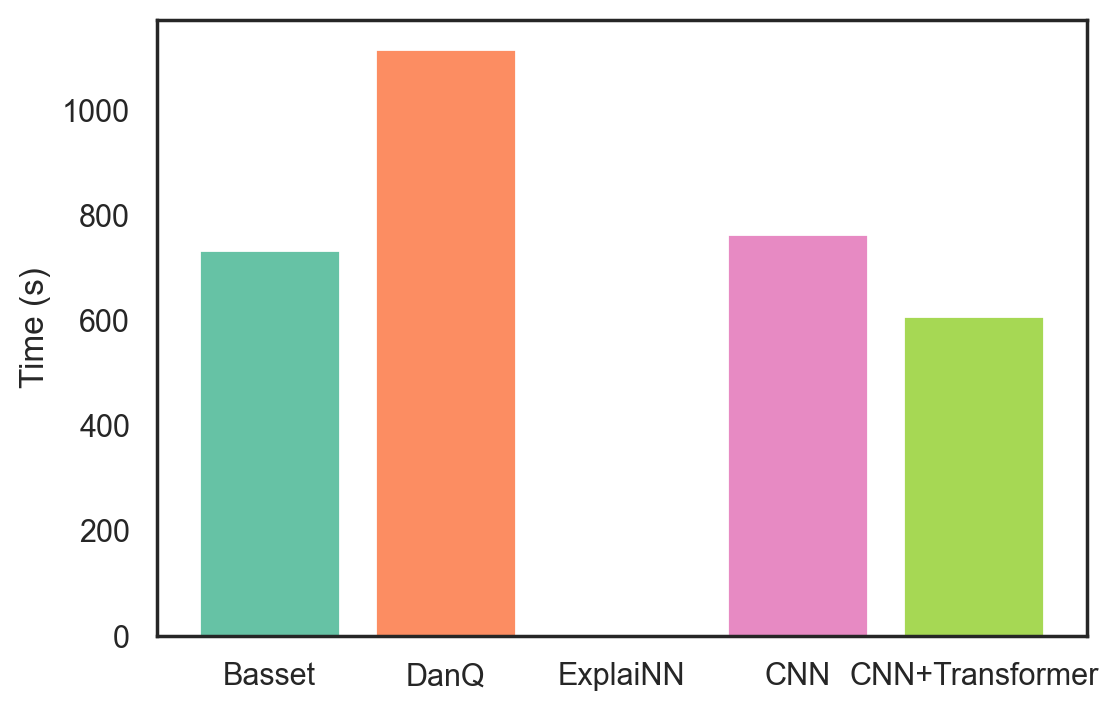

In [98]:
##绘制不同方法解释motif的时间
train_time_ls = [735,1117,0,765,608]
colors = sns.color_palette('Set2', 5)
plt.figure(figsize=(6,4))
plt.bar(range(5),train_time_ls,color=colors)
plt.xticks(range(5),["Basset","DanQ","ExplaiNN","CNN","CNN+Transformer"])
plt.ylabel("Time (s)")
plt.savefig("/mnt/d/work/2023/1/NCBenchmark/Figure/Figure_fig/explainn/Training_Time.pdf",bbox_inches='tight')

In [143]:
df_jund = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/TF/GM12878/ELF1_JUND_JUND_reads.bed",header=None,sep="\t").iloc[:,0:4]
df_jund.columns = ["chrom","start","end","reads"]

df_elf1 = pd.read_csv("/mnt/d/work/2023/1/NCBenchmark/TF/GM12878/ELF1_JUND_ELF1_reads.bed",header=None,sep="\t").iloc[:,0:4]
df_elf1.columns = ["chrom","start","end","reads"]

#对df_jund计算RPM
total_reads = 19712870
df_jund["RPM"] = df_jund["reads"] / total_reads * 10**6

#对df_elf1计算RPM
total_reads = 116063922
df_elf1["RPM"] = df_elf1["reads"] / total_reads * 10**6

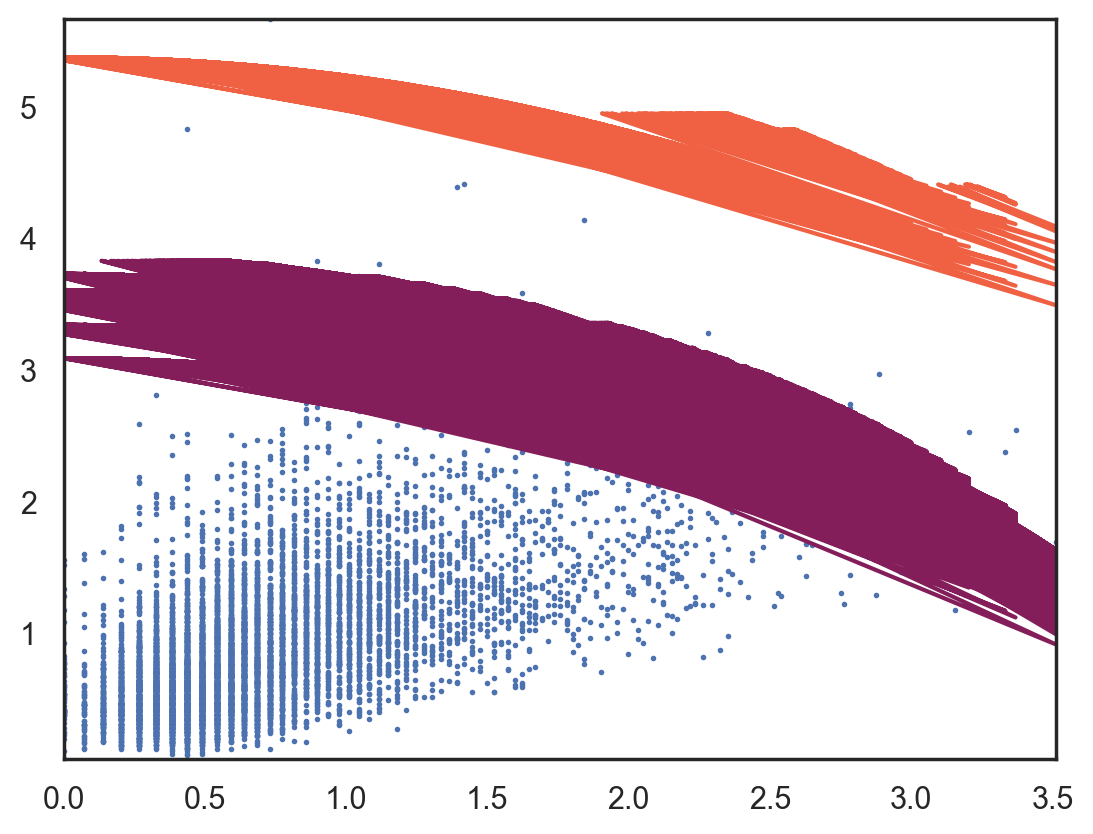

In [151]:
x = np.log2(df_jund["RPM"]+1)
y = np.log2(df_elf1["RPM"]+1)
plt.scatter(x,y,s=1)

# plt.contour(np.unique(x), np.unique(y), z.reshape(x.size, y.size))

/tmp/ipykernel_3897601/1035063865.py:17: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  k = kde.gaussian_kde([x, y])


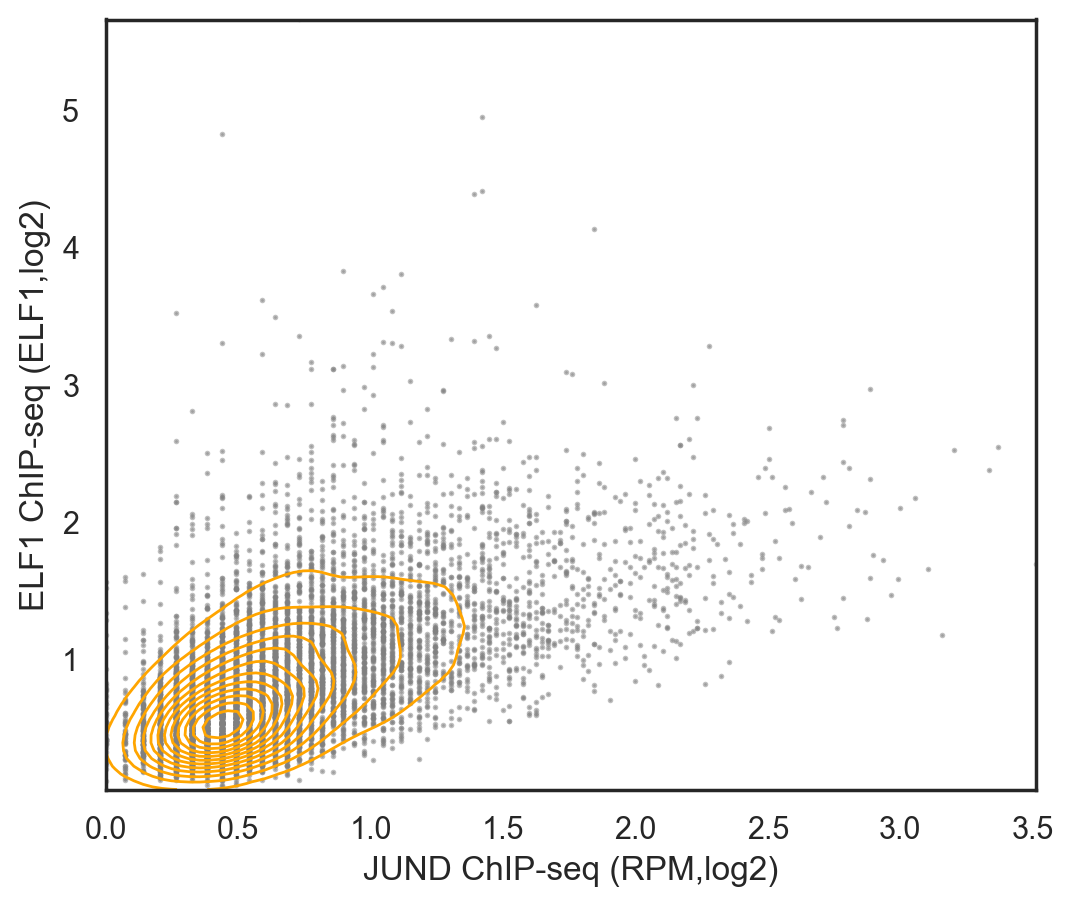

In [171]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kde

# 假设你已经加载了 df_jund 和 df_elf1 数据框

# 计算 log2(RPM+1)
x = np.log2(df_jund["RPM"] + 1)
y = np.log2(df_elf1["RPM"] + 1)

# 创建散点图
plt.figure(figsize=(6, 5))  # 设置图形大小
plt.scatter(x, y, s=1, c="gray", alpha=0.5)  # 绘制散点图，设置颜色和透明度

# 计算等高线数据
nbins = 100  # 等高线网格的密度
k = kde.gaussian_kde([x, y])
xi, yi = np.mgrid[x.min():x.max():nbins * 1j, y.min():y.max():nbins * 1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

# 绘制等高线
plt.contour(xi, yi, zi.reshape(xi.shape), 15, colors="orange", linewidths=1)  # 6 代表等高线数量

# 设置坐标轴标签
plt.xlabel("JUND ChIP-seq (RPM,log2)")
plt.ylabel("ELF1 ChIP-seq (ELF1,log2)")
plt.savefig("/mnt/d/work/2023/1/NCBenchmark/TF/GM12878/ELF1_JUND.pdf",bbox_inches='tight')
# 显示图形